In [1]:
from herbie import FastHerbie
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import datetime
import cv2
from ultralytics import YOLO
import os

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [30]:
dt = datetime.datetime.now()
date = "2024-05-15"

FH = FastHerbie(
    DATES=[date],
    model="ifs",
    product="oper",
    fxx=range(18, 21, 3),
)

search = ":[u|v]:1000:"
# FH.download(search)
ds = FH.xarray(search)

valid_time = ds["valid_time"]
lat = ds["latitude"][280:441]  # get lat 20, -10
lon = ds["longitude"][1040:1361]  # get lon 80, 160

c:\Users\falbas\miniconda3\envs\python3.9\lib\site-packages\herbie\core.py:1097: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


In [59]:
u = ds["u"][280:441, 1040:1361]
v = ds["v"][280:441, 1040:1361]
ws = np.sqrt(u**2 + v**2)

In [56]:
model = YOLO("model/best.pt")
img = cv2.imread(f"output/12/2024-05-15/2024-05-15T18.00.00.000000000.jpg")

ress = []
result = model(img)
for detection in result[0].boxes.data:
    x0, y0 = (int(detection[0]), int(detection[1]))
    x1, y1 = (int(detection[2]), int(detection[3]))
    score = round(float(detection[4]), 2)
    cls = int(detection[5])
    object_name = model.names[cls]
    label = f"{object_name} {score}"

    midx = int(x0 + ((x1 - x0) / 2))
    midy = int(y0 + ((y1 - y0) / 2))

    w = result[0].orig_shape[1]
    h = result[0].orig_shape[0]
    mlat = round(float(20 - (midy * 40 / h)), 5)
    mlon = round(float((midx * 80 / w) + 80), 5)

    wlon = round(float((x0 * 80 / w) + 80), 5)
    nlat = round(float(20 - (y0 * 40 / h)), 5)
    elon = round(float((x1 * 80 / w) + 80), 5)
    slat = round(float(20 - (y1 * 40 / h)), 5)

    widx = find_nearest(lon.values, wlon)
    nidx = find_nearest(lat.values, nlat)
    eidx = find_nearest(lon.values, elon)
    sidx = find_nearest(lat.values, slat)

    # subu = u[nidx:sidx, widx:eidx]
    # subv = v[nidx:sidx, widx:eidx]
    # ws = np.sqrt(subu**2 + subv**2)
    # maxws = ws.values.max() * 3.6

    subws = ws[nidx:sidx, widx:eidx]
    maxws = subws.values.max() * 3.6

    ress.append(
        {
            "mlat": mlat,
            "mlon": mlon,
            "maxws": maxws,
            "widx": widx,
            "nidx": nidx,
            "eidx": eidx,
            "sidx": sidx,
        }
    )


0: 352x640 1 tropical_cyclone, 50.6ms
Speed: 5.0ms preprocess, 50.6ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


In [66]:
ress

[{'mlat': 3.85093,
  'mlon': 141.30841,
  'maxws': 35.66754684448242,
  'widx': 219,
  'nidx': 46,
  'eidx': 271,
  'sidx': 83}]

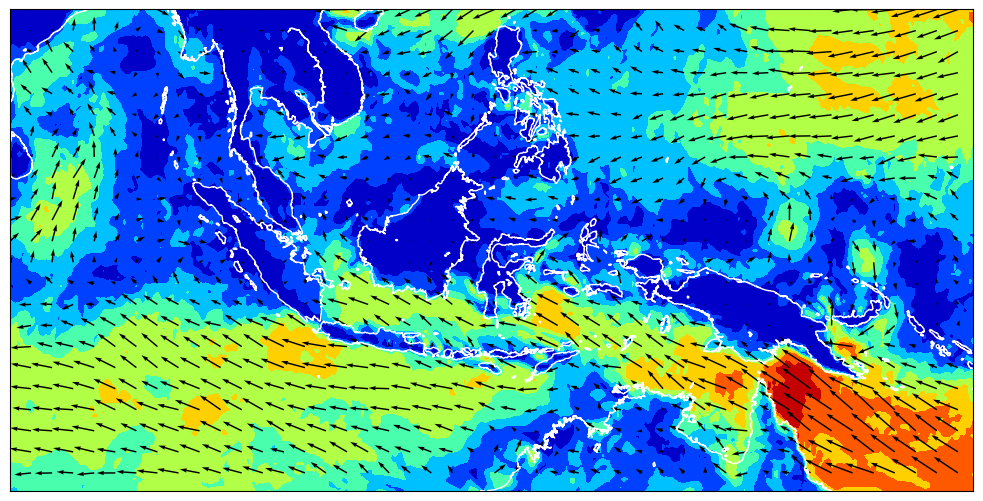

In [64]:
dpi = 100
zoom = 3
fig = plt.figure(figsize=(len(lon) * zoom / dpi, len(lat) * zoom / dpi))

m = Basemap(
    projection="cyl",
    llcrnrlon=lon[0].values,
    llcrnrlat=lat[-1].values,
    urcrnrlon=lon[-1].values,
    urcrnrlat=lat[0].values,
    resolution="i",
)
m.drawcoastlines(color="white")

cf = plt.contourf(lon, lat, ws, cmap='jet')

skip = 7
q = m.quiver(
    lon[::skip],
    lat[::skip],
    u[::skip, ::skip],
    v[::skip, ::skip],
    scale_units="xy",
    scale=5,
    width=0.0015,
)

plt.tight_layout(pad=0)
plt.show()
plt.close()

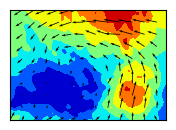

In [70]:
for i in ress:
    sublat = lat[i["nidx"]:i["sidx"]]
    sublon = lon[i["widx"]:i["eidx"]]
    subu = u[i["nidx"]:i["sidx"], i["widx"]:i["eidx"]]
    subv = v[i["nidx"]:i["sidx"], i["widx"]:i["eidx"]]
    subws = np.sqrt(subu**2 + subv**2)

    dpi = 100
    zoom = 3
    fig = plt.figure(figsize=(len(sublon) * zoom / dpi, len(sublat) * zoom / dpi))

    m = Basemap(
        projection="cyl",
        llcrnrlon=sublon[0].values,
        llcrnrlat=sublat[-1].values,
        urcrnrlon=sublon[-1].values,
        urcrnrlat=sublat[0].values,
        resolution="i",
    )
    m.drawcoastlines(color="white")

    cf = plt.contourf(sublon, sublat, subws, cmap='jet')

    skip = 4
    q = m.quiver(
        sublon[::skip],
        sublat[::skip],
        subu[::skip, ::skip],
        subv[::skip, ::skip],
        scale_units="xy",
        scale=7,
        width=0.005,
    )

    plt.tight_layout(pad=0)
    plt.show()
    plt.close()